# Source Position Transform in Curved Arcs

In this notebook, we explore degeneracies between source and lensing inference with curved arcs.
We perform inferences on single extended arcs to see what ellipticity degeneracy components are been broken in the non-linear curved regime.


Author: Simon Birrer

Requirements: lenstronomy v1.8.1


In [1]:
from lenstronomy.Util import util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Plots import lens_plot
from lenstronomy.Util import simulation_util as sim_util
from lenstronomy.Util import param_util, image_util

import numpy as np
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in log10


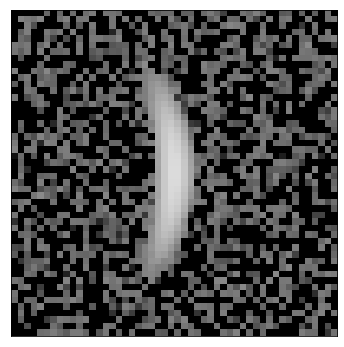

In [2]:
# make mock

num_arcs = 1

curved_arc_type = 'CURVED_ARC_SIS_MST'  # 'CURVED_ARC_SIS_MST',  'CURVED_ARC_SPP' or 'CURVED_ARC_CONST_MST'
source_type = 'GAUSSIAN'  # 'GAUSSIAN' or 'SERSIC'

    
# data specifics
sigma_bkg = .05  #  background noise per pixel (Gaussian)
exp_time = 1000.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 50  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'NONE'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, sigma_bkg)
kwargs_data['exposure_time'] = exp_time * np.ones_like(kwargs_data['image_data'])
data_class = ImageData(**kwargs_data)
# generate the psf variables

kwargs_psf = {'psf_type': psf_type, 'pixel_size': deltaPix, 'fwhm': fwhm}
#kwargs_psf = sim_util.psf_configure_simple(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, kernel=kernel)
psf_class = PSF(**kwargs_psf)




# lensing quantities
kwargs_arc_true = [{'tangential_stretch': 5, 'radial_stretch':1, 'curvature': 0.5, 
                'direction': 0., 'center_x': 0, 'center_y': 0}]

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = [curved_arc_type]
lens_model_class = LensModel(lens_model_list=lens_model_list)



source_x = 0.
source_y = 0.


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 1
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
if source_type == 'SERSIC':
    kwargs_source_true = [{'amp': 1000, 'R_sersic': 0.07, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}]
    source_model_list = ['SERSIC_ELLIPSE']
else:
    kwargs_source_true = [{'amp': 100, 'sigma': 0.05, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}]
    source_model_list = ['GAUSSIAN_ELLIPSE']

source_model_class = LightModel(light_model_list=source_model_list)




kwargs_numerics = {'supersampling_factor': 1}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_arc_true, kwargs_source_true)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=sigma_bkg)
image_sim = image_sim + bkg + poisson

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim


kwargs_model = {'lens_model_list': lens_model_list, 
                 'source_light_model_list': source_model_list,
                 }


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()


In [3]:
# set up fitting


ellipticity_fixed = False

lens_model_list_arc = []
fixed_lens_arc = []
kwargs_lens_init_arc = []
kwargs_lens_sigma_arc = []
kwargs_lens_lower_arc = []
kwargs_lens_upper_arc = []
index_lens_model_list = []

kwargs_lens_arc_true = []

# joint modeling of the individual cutouts


for lens_index in range(num_arcs):
    kwargs_lens_init_arc.append(kwargs_arc_true[lens_index])
    lens_model_list_arc.append(curved_arc_type)
    #if i == 0:
    #    fixed_lens_arc.append({'center_x': x_image[i], 'center_y': y_image[i], 'radial_stretch':kwargs_arc_true['radial_stretch']})
    #else:
    fixed_lens_arc.append({'center_x': 0, 'center_y': 0})
    kwargs_lens_init_arc.append(kwargs_arc_true[lens_index])

    kwargs_lens_sigma_arc.append({'tangential_stretch': 0.5, 'radial_stretch':.1, 'curvature': 0.5, 
                'direction': np.pi/100})
    kwargs_lens_lower_arc.append({'tangential_stretch': -100, 'radial_stretch':-1.9, 'curvature': 0.0005, 
                'direction': -2*np.pi})
    kwargs_lens_upper_arc.append({'tangential_stretch': 100, 'radial_stretch':1.9, 'curvature': 5, 
                'direction': 2*np.pi})


lens_params = [kwargs_lens_init_arc, kwargs_lens_sigma_arc, fixed_lens_arc, kwargs_lens_lower_arc, kwargs_lens_upper_arc]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append(kwargs_source_true[0])
if source_type == 'SERSIC':
    kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})
else:
    kwargs_source_sigma.append({'sigma': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'sigma': 0.01, 'center_x': -10, 'center_y': -10})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'sigma': 10, 'center_x': 10, 'center_y': 10})

    
if source_type == 'SERSIC':
    fixed_source = [{'R_sersic': kwargs_source_true[0]['R_sersic'],
                         'n_sersic': kwargs_source_true[0]['n_sersic'],
                         'center_x': kwargs_source_true[0]['center_x'], 
                         'center_y': kwargs_source_true[0]['center_y']}]
else:
    fixed_source = [{'sigma': kwargs_source_true[0]['sigma'],
                         'center_x': kwargs_source_true[0]['center_x'], 
                         'center_y': kwargs_source_true[0]['center_y']}]
if ellipticity_fixed:
    fixed_source[0]['e1'] = kwargs_source_true[0]['e1']
    fixed_source[0]['e2'] = kwargs_source_true[0]['e2']
    
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params}


# numerical options and fitting sequences

kwargs_constraints = {}

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False}

kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'joint-linear'}





In [4]:
# run inference
from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 200, 'n_iterations': 200}],
        ['MCMC', {'n_burn': 500, 'n_run': 4000, 'walkerRatio': 10, 'sigma_scale': .1}]
]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')




Computing the PSO ...
10
20
30
40
50
60
70
80
90
100


  0%|          | 0/4500 [00:00<?, ?it/s]

Converged after 107 iterations!
Best fit found:  -1240.5073320185013 [5.084465578277392, 0.9897313198341877, 0.48976212655970536, -0.00048219743030089395, 0.013901159646668907, 0.0005534375841229918]
-0.9951924043469725 reduced X^2 of best position
-1240.5073320185013 logL
2493.0 effective number of data points
[{'tangential_stretch': 5.084465578277392, 'radial_stretch': 0.9897313198341877, 'curvature': 0.48976212655970536, 'direction': -0.00048219743030089395, 'center_x': 0, 'center_y': 0}] lens result
[{'amp': 1, 'sigma': 0.05, 'e1': 0.013901159646668907, 'e2': 0.0005534375841229918, 'center_x': 0.0, 'center_y': 0.0}] source result
[] lens light result
[] point source result
{} special param result
15.970277070999146 time used for  PSO


100%|██████████| 4500/4500 [03:17<00:00, 22.69it/s]

Computing the MCMC...
Number of walkers =  60
Burn-in iterations:  500
Sampling iterations (in current run): 4500
197.51722693443298 time taken for MCMC sampling
213.50287222862244 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/multi_patch_plot.py:166: RuntimeWarning: invalid value encountered in log10
  image_plot = np.log10(image)


-0.9924233933907719 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9924233933907719


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


number of non-linear parameters in the MCMC process:  6
parameters in order:  ['tangential_stretch_lens0', 'radial_stretch_lens0', 'curvature_lens0', 'direction_lens0', 'e1_source_light0', 'e2_source_light0']
number of evaluations in the MCMC process:  240000


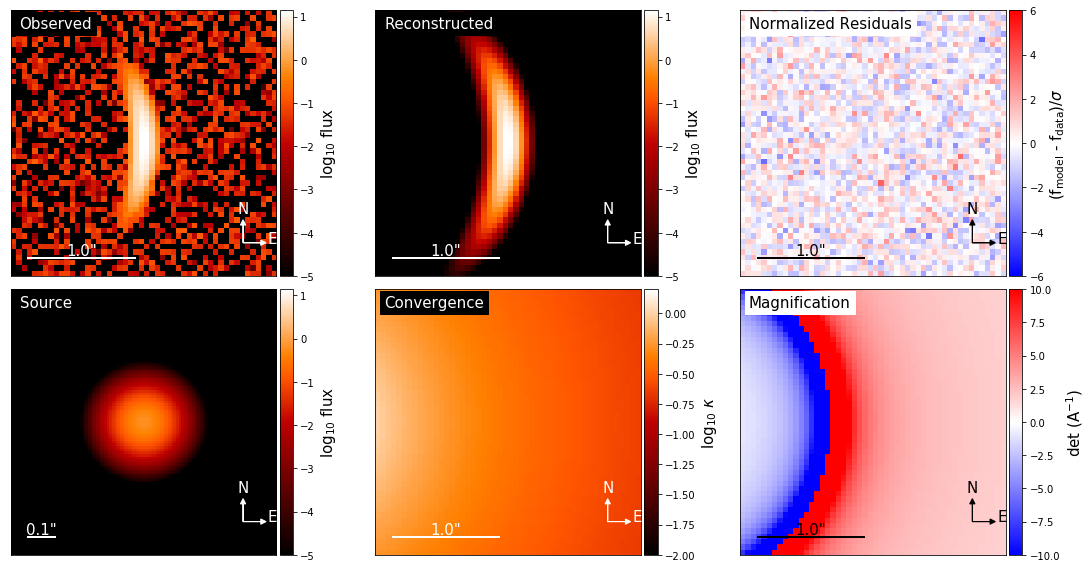

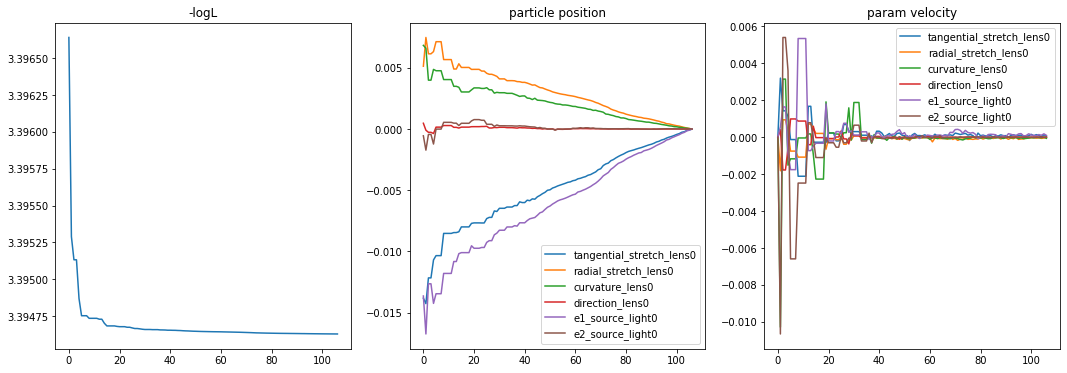

<Figure size 432x288 with 0 Axes>

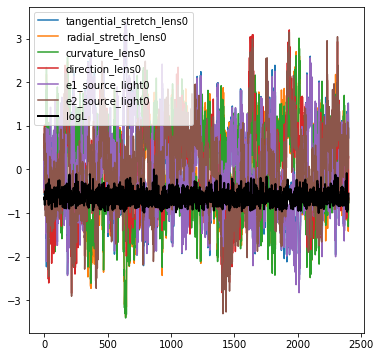

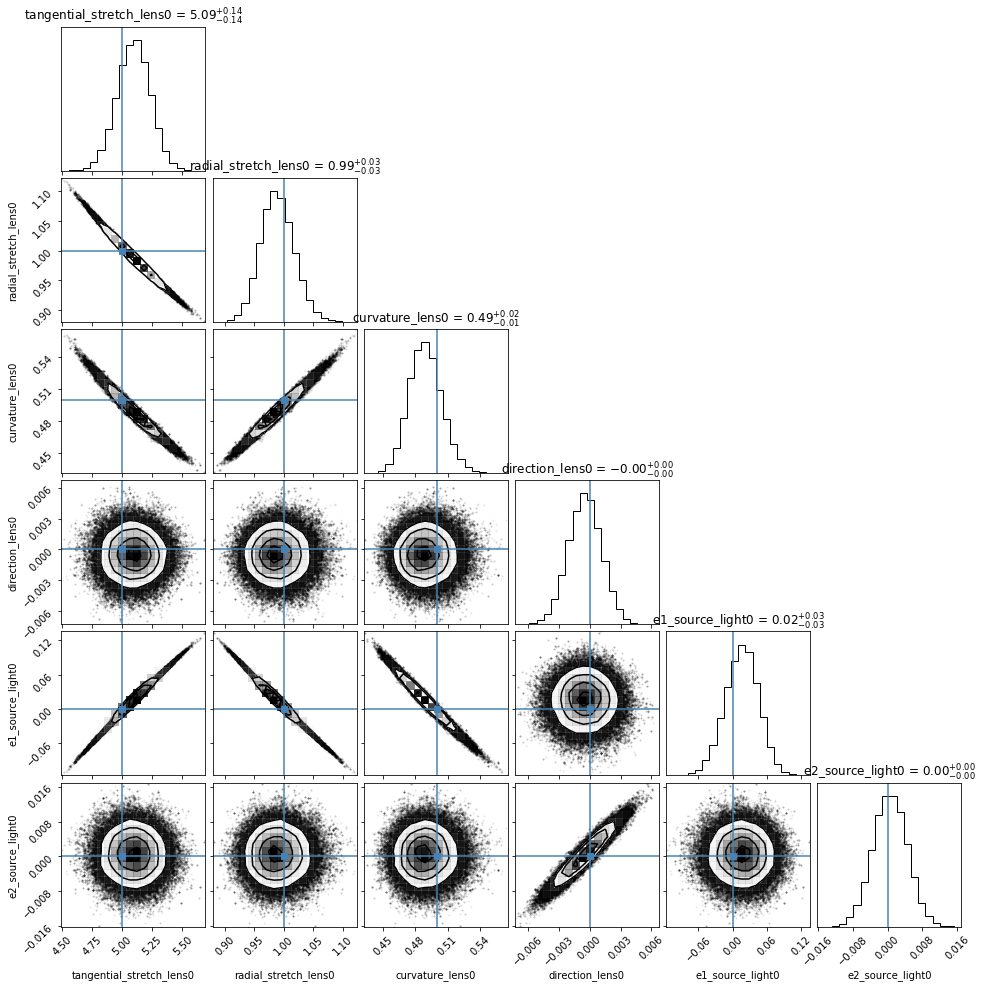

In [5]:
# diagnostics




from lenstronomy.Plots.multi_patch_plot import MultiPatchPlot
multi_plot = MultiPatchPlot(multi_band_list=multi_band_list, 
                            kwargs_model=kwargs_model, kwargs_params=kwargs_result, 
                            multi_band_type='joint-linear',
                            kwargs_likelihood=None, verbose=True, cmap_string="gist_heat")

f, axes = multi_plot.plot_main()
f.show()

from lenstronomy.Plots import chain_plot
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner

param = fitting_seq.param_class
truths = param.kwargs2args(kwargs_lens=kwargs_arc_true, kwargs_source=kwargs_source_true)
plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True, truths=truths)

In [6]:
# TODO: re-fitting with PSO under constant source property with ellipticity

def shear_transform_fit(kwargs_arc, kwargs_source, e1, e2, lens_index=0, source_index=0):

    kwargs_source_trans = copy.deepcopy(kwargs_source)
    #direction = kwargs_arc[lens_index]['direction']
    #e1 = np.cos(2*direction) * e
    #e2 = np.sin(2*direction) * e
    kwargs_source_trans[source_index]['e1'] += e1
    kwargs_source_trans[source_index]['e2'] += e2
    
    # fix ellipticity in fitting configuration
    _fixed_source = copy.deepcopy(fixed_source)
    _fixed_source[source_index] = kwargs_source_trans[source_index]
    _source_params = [kwargs_source_init, kwargs_source_sigma, _fixed_source, kwargs_lower_source, kwargs_upper_source]
    _kwargs_params = {'lens_model': lens_params,
                     'source_model': _source_params}
    # run PSO
    _fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, _kwargs_params)

    _fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 200, 'n_iterations': 200}]]

    chain_list = _fitting_seq.fit_sequence(_fitting_kwargs_list)
    _kwargs_result = _fitting_seq.best_fit()
    kwargs_arc_trans = _kwargs_result['kwargs_lens']
    return kwargs_arc_trans, kwargs_source_trans


def shear_transform_const(kwargs_arc, kwargs_source, e1, e2, lens_index=0, source_index=0):
    kwargs_arc_trans = copy.deepcopy(kwargs_arc)
    kwargs_source_trans = copy.deepcopy(kwargs_source)
    #direction = kwargs_arc_trans[lens_index]['direction']
    #e1 = np.cos(2*direction) * e
    #e2 = np.sin(2*direction) * e
    e = np.sqrt(e1**2 + e2**2)
    kwargs_source_trans[source_index]['e1'] += e1
    kwargs_source_trans[source_index]['e2'] += e2
    #kwargs_source_trans[source_index]['sigma'] *= np.sqrt(1.-e**2)  # transform for CONST_MST
    
    kwargs_arc_trans[lens_index]['tangential_stretch'] *= 1./(1.-e) * np.sqrt(1.-e**2)
    kwargs_arc_trans[lens_index]['radial_stretch'] *= 1./(1.+e) * np.sqrt(1.-e**2)
    return kwargs_arc_trans, kwargs_source_trans

def shear_transform_spt(kwargs_arc, kwargs_source, e1, e2, lens_index=0, source_index=0):
    kwargs_arc_trans = copy.deepcopy(kwargs_arc)
    kwargs_source_trans = copy.deepcopy(kwargs_source)
    #direction = kwargs_arc_trans[lens_index]['direction']
    #e1 = np.cos(2*direction) * e
    #e2 = np.sin(2*direction) * e
    kwargs_source_trans[source_index]['e1'] += e1
    kwargs_source_trans[source_index]['e2'] += e2
    
    kwargs_arc_trans[lens_index]['gamma1'] = -e1
    kwargs_arc_trans[lens_index]['gamma2'] = -e2
    return kwargs_arc_trans, kwargs_source_trans

def shear_transform(kwargs_arc, kwargs_source, e1, e2, curved_arc_type, lens_index=0, source_index=0):
    if curved_arc_type == 'CURVED_ARC_SIS_MST':
        return shear_transform_fit(kwargs_arc, kwargs_source, e1, e2, lens_index, source_index)
    elif curved_arc_type == 'CURVED_ARC_CONST_MST':
        return shear_transform_const(kwargs_arc, kwargs_source, e1, e2, lens_index, source_index)
    elif curved_arc_type == 'CURVED_ARC_SPT':
        return shear_transform_spt(kwargs_arc, kwargs_source, e1, e2, lens_index, source_index)




In [11]:
# plot fit along the degneracy axis with source and reconstruction


def illustrate_shape_distortion(curved_arc_type_transform, e1_list, e2_list):
    

    f, axes = plt.subplots(5, len(e1_list), figsize=(len(e1_list)*2, 5*2))


    ext_arc = LensModelExtensions(LensModel([curved_arc_type_transform]))
    kwargs_model_transform = {'lens_model_list': [curved_arc_type_transform], 
                              'source_light_model_list': source_model_list}

    for i, e1 in enumerate(e1_list):
        e2 = e2_list[i]
        kwargs_arc_trans, kwargs_source_trans = shear_transform(kwargs_arc_true, kwargs_source_true, e1=e1, e2=e2, curved_arc_type=curved_arc_type_transform)
        kwargs_result_trans = {'kwargs_lens': kwargs_arc_trans,
                              'kwargs_source': kwargs_source_trans}
        multi_plot = MultiPatchPlot(multi_band_list=multi_band_list, 
                                    kwargs_model=kwargs_model_transform, kwargs_params=kwargs_result_trans, 
                                    multi_band_type='joint-linear',
                                    kwargs_likelihood=None, verbose=True, cmap_string="gist_heat")
        image_joint, model_joint, norm_residuals_joint = multi_plot.image_joint()
        multi_plot.source_plot(ax=axes[0, i], delta_pix=0.01, num_pix=100, no_support=True)
        multi_plot.model_plot(ax=axes[2, i], image_names=True, no_support=True)
        multi_plot.normalized_residual_plot(ax=axes[3, i], v_min=-6, v_max=6, no_support=True)
        ax = axes[1, i]
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        # TODO compute local curved arc parameters from lens model extensions
        kwargs_arc = ext_arc.curved_arc_estimate(0, 0, kwargs_arc_trans)
        lens_plot.plot_arc(ax, stretch_scale=0.1, with_centroid=False, linewidth=1, color='k', **kwargs_arc)
        #lens_plot.curved_arc_illustration(axes[3, i], lens_model_class, kwargs_arc_trans, stretch_scale=0.1, with_centroid=False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.autoscale(False)

        model_band = multi_plot.model_band_list[0]
        image_model = model_band.image_model_class
        kwargs_params = model_band.kwargs_model
        kwargs_lens = kwargs_params['kwargs_lens']
        lens_model = image_model.LensModel
        x_grid, y_grid = image_model.Data.pixel_coordinates
        curl = lens_model.curl(x_grid, y_grid, kwargs_lens)
        ax = axes[4, i]
        ax.matshow(curl, origin='lower', vmin=-1, vmax=1, cmap='bwr')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.autoscale(False)

    axes[0, 0].get_yaxis().set_visible(True)
    axes[0, 0].set_yticks([])
    axes[0, 0].set_ylabel('Source', fontsize=20) 

    axes[1, 0].get_yaxis().set_visible(True)
    axes[1, 0].set_yticks([])
    axes[1, 0].set_ylabel('Lens', fontsize=20) 

    axes[2, 0].get_yaxis().set_visible(True)
    axes[2, 0].set_yticks([])
    axes[2, 0].set_ylabel('Image', fontsize=20) 

    axes[3, 0].get_yaxis().set_visible(True)
    axes[3, 0].set_yticks([])
    axes[3, 0].set_ylabel('Residual', fontsize=20) 

    axes[4, 0].get_yaxis().set_visible(True)
    axes[4, 0].set_yticks([])
    axes[4, 0].set_ylabel('Curl', fontsize=20) 


    f.tight_layout()
    return f


-0.9970113534405886 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405886
-0.9970113534405886 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405886
-0.9970113534405888 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405888
-0.9970113534405889 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405891
-0.9970113534405882 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405882


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  """
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


Computing the PSO ...
10
20
30
40
50
60
70
80
Converged after 88 iterations!
Best fit found:  -1392.7770792782226 [3.3854212668805435, 1.5134301164907178, 0.8384194942908855, -0.0006243106757569359]
-1.1164545725677135 reduced X^2 of best position
-1392.7770792782226 logL
2495.0 effective number of data points
[{'tangential_stretch': 3.3854212668805435, 'radial_stretch': 1.5134301164907178, 'curvature': 0.8384194942908855, 'direction': -0.0006243106757569359, 'center_x': 0, 'center_y': 0}] lens result
[{'amp': 100, 'sigma': 0.05, 'e1': -0.4, 'e2': 0.0, 'center_x': 0.0, 'center_y': 0.0}] source result
[] lens light result
[] point source result
{} special param result
13.461184978485107 time used for  PSO
-1.1142216634225781 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.1142216634225781
Computing the PSO ...
10
20
30
40
50
60
70
Converged after 78 iterations!
Best fit found:  -1266.363631714537 [4.153722352414635, 1.2233729539171516, 0.623358408377890

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


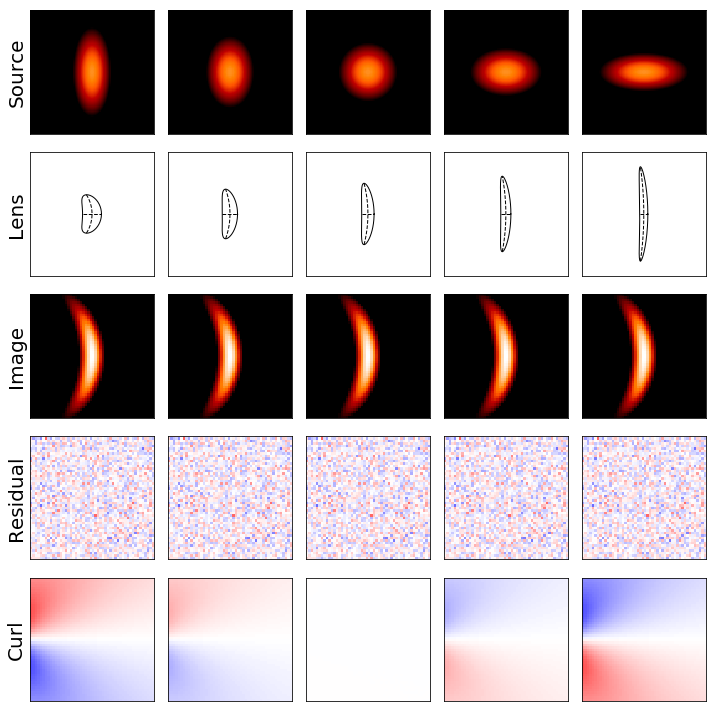

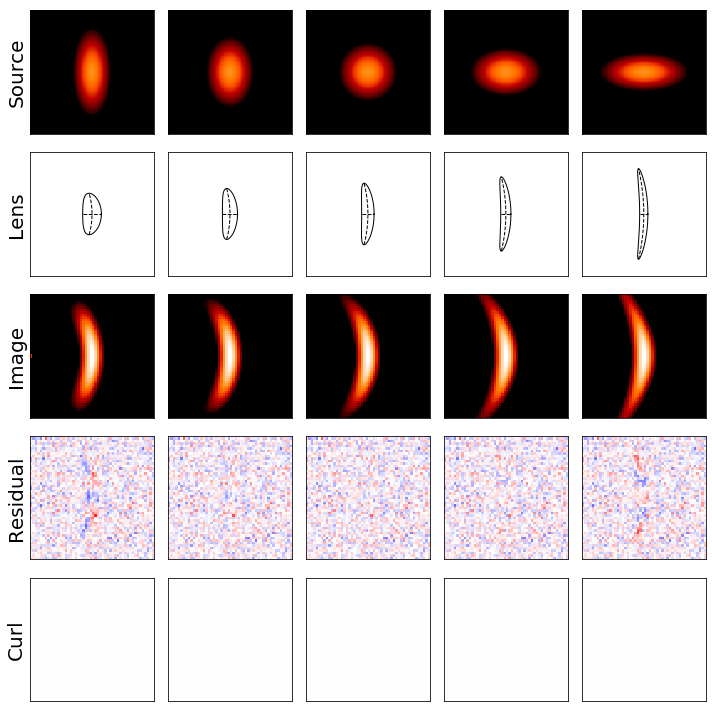

In [15]:
e1_list = [-0.4, -0.2, 0, 0.2, 0.4]
e2_list = np.zeros_like(e1_list)
curved_arc_type_transform = 'CURVED_ARC_SPT'
f = illustrate_shape_distortion(curved_arc_type_transform, e1_list, e2_list)
#plt.savefig('/Users/sibirrer/Science/Publications/ArcPhenomenology/AAS/figures/degeneracy_spt_on_axis.pdf', format='pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None) 
f.show()


curved_arc_type_transform = 'CURVED_ARC_SIS_MST'
f = illustrate_shape_distortion(curved_arc_type_transform, e1_list, e2_list)
#plt.savefig('/Users/sibirrer/Science/Publications/ArcPhenomenology/AAS/figures/degeneracy_on_axis.pdf', format='pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None) 
f.show()


-0.9970113534405886 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405886
-0.9970113534405889 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405889
-0.9970113534405888 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405888
-0.9970113534405889 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405889
-0.9970113534405886 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9970113534405886


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  """
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


Computing the PSO ...
10
20
30
40
50
60
70
80
Converged after 84 iterations!
Best fit found:  -8017.060105851615 [4.805302915610215, 1.05045798929099, 0.46283173718410237, -0.1800411095002639]
-6.426501086855002 reduced X^2 of best position
-8017.060105851615 logL
2495.0 effective number of data points
[{'tangential_stretch': 4.805302915610215, 'radial_stretch': 1.05045798929099, 'curvature': 0.46283173718410237, 'direction': -0.1800411095002639, 'center_x': 0, 'center_y': 0}] lens result
[{'amp': 100, 'sigma': 0.05, 'e1': 0.0, 'e2': -0.4, 'center_x': 0.0, 'center_y': 0.0}] source result
[] lens light result
[] point source result
{} special param result
13.173481941223145 time used for  PSO
-6.4136480846812916 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  6.4136480846812916
Computing the PSO ...
10
20
30
40
50
60
70
Converged after 78 iterations!
Best fit found:  -2624.999739661006 [4.958589734109919, 1.0159675675009052, 0.4971743943786995, -0.0824058

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


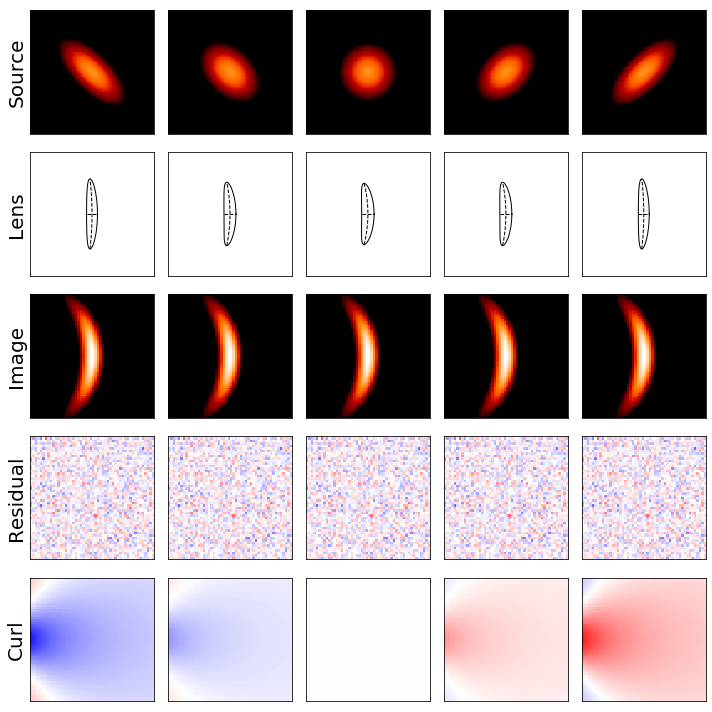

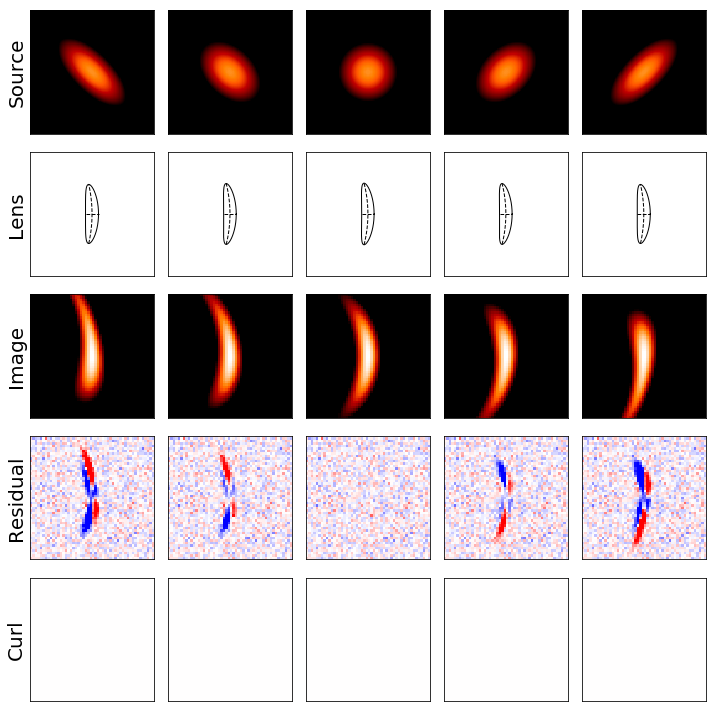

In [16]:
e2_list = [-0.4, -0.2, 0, 0.2, 0.4]
e1_list = np.zeros_like(e1_list)
curved_arc_type_transform = 'CURVED_ARC_SPT'
f = illustrate_shape_distortion(curved_arc_type_transform, e1_list, e2_list)
#plt.savefig('/Users/sibirrer/Science/Publications/ArcPhenomenology/AAS/figures/degeneracy_spt_off_axis.pdf', format='pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None) 
f.show()


curved_arc_type_transform = 'CURVED_ARC_SIS_MST'
f = illustrate_shape_distortion(curved_arc_type_transform, e1_list, e2_list)
#plt.savefig('/Users/sibirrer/Science/Publications/ArcPhenomenology/AAS/figures/degeneracy_off_axis.pdf', format='pdf', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, transparent=False, bbox_inches=None, pad_inches=0.1, frameon=None, metadata=None) 
f.show()


Computing the PSO ...
10
20
30
40
50
60
70
Converged after 71 iterations!
Best fit found:  -1248.1224226802747 [4.571383693382744, 1.106811505735862, 0.5532335269901373, -0.0007538580044169718]
-1.0004989360162522 reduced X^2 of best position
-1248.1224226802747 logL
2495.0 effective number of data points
[{'tangential_stretch': 4.571383693382744, 'radial_stretch': 1.106811505735862, 'curvature': 0.5532335269901373, 'direction': -0.0007538580044169718, 'center_x': 0, 'center_y': 0}] lens result
[{'amp': 100, 'sigma': 0.05, 'e1': -0.1, 'e2': 0.0, 'center_x': 0.0, 'center_y': 0.0}] source result
[] lens light result
[] point source result
{} special param result
10.902770280838013 time used for  PSO
[4.571383693382744, 1.106811505735862, 0.5532335269901373, -0.0007538580044169718, -0.1, 0.0]


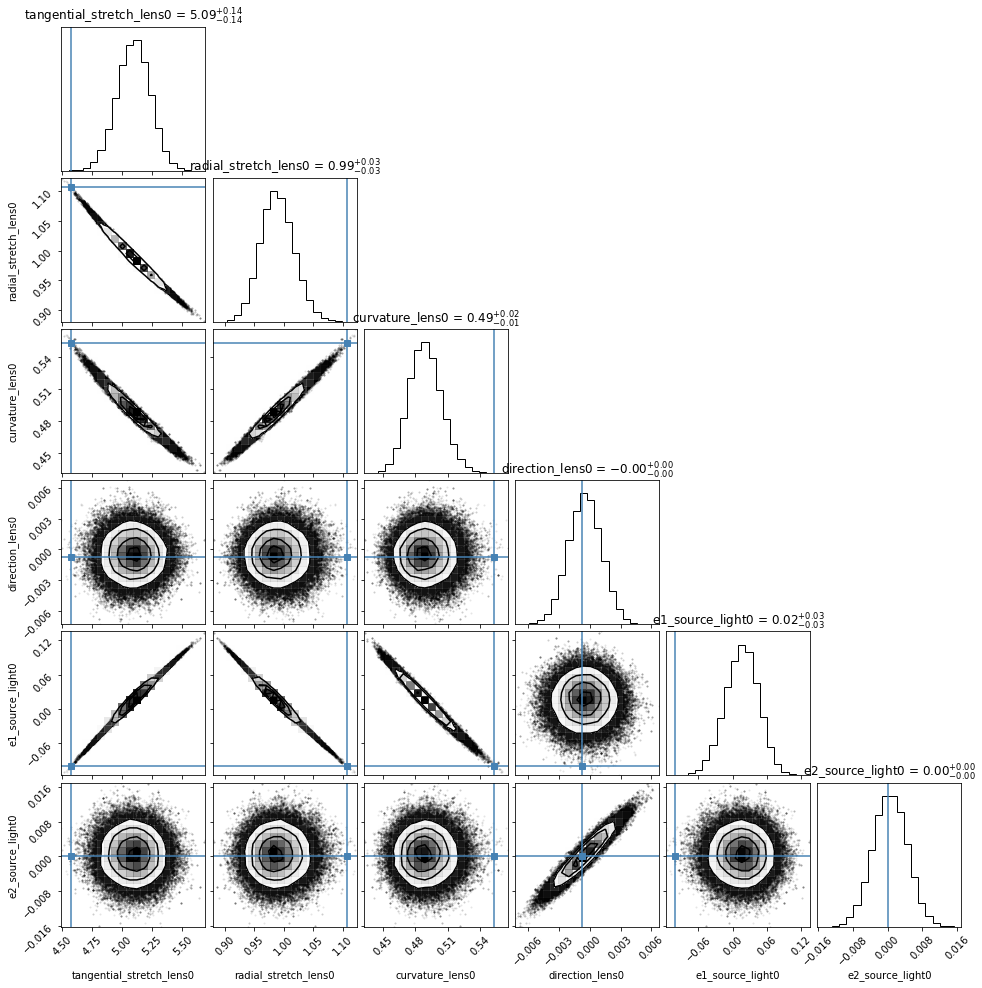

In [14]:
param = fitting_seq.param_class
kwargs_arc_trans, kwargs_source_trans = shear_transform(kwargs_arc_true, kwargs_source_true, e1=-0.1, e2=0, curved_arc_type=curved_arc_type)
truths = param.kwargs2args(kwargs_lens=kwargs_arc_trans, kwargs_source=kwargs_source_trans)
print(truths)
plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True, truths=truths)